### Загрузка необходимых библиотек:

In [1]:
# Основные фреймворки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Настройка визуализации
import matplotlib
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = TEXT_COLOR
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.markersize'] = 15
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

sns.set_style('darkgrid')

In [3]:
# Импорт используемых фреймворков
from phik import phik_matrix
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

------------------

In [4]:
# Загрузка данных
df = pd.read_csv('sensor.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True).drop('Unnamed: 0', axis=1)
df.head(2)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL


In [5]:
# Временной диапазон 
start = df.index[0]
stop = df.index[-1]

In [6]:
# Выделим в отдельные переменные записи, которые не соответствуют статусу "NORMAL" 
df_broken = df[df.machine_status=='BROKEN']
df_recovering = df[df.machine_status=='RECOVERING']

---------------

### Предобработка данных:

Так как основная задача проекта - обнаружение аномалий, то перед реализацией модели необходимо задаться вопросом о "природе" выбросов (т.е. чем они могут быть вызваны).

В данном случае рационально использовать обучение без учителя для обнаружения аномалий. Так как при классификации с учителем, где целевой признак представляет бинарный вид "NORMAL"/"BROKEN", модель просто будет указывать на поломку, а не предупреждать инженера о возможном отказе насоса.

Также важно правильно предобработать данные, чтобы не потерять информацию, которая может быть полезной и содержать нетипичные значения. 

**Заполнение пропусков**

-	датчик 15 удаляется, так как  содержит 100% пропусков;
-	датчик 50 удаляется из таблицы показаний, так как содержит 1/3 значе-ний NaN, восстановление которых будет затруднительно.
-	в датчиках: 00, 06, 07, 08, 09 заменим значения NaN на 0, так как боль-шинство значений отсутствуют после поломки насоса и падения пока-заний в 0;
-	в остальных датчиках возможно заменить пропуски или удалить их, так как в признаках отсутствует 799 данных, что составляет 0.36%, в каче-стве замены возможно использовать следующие методы: медианное значение, ‘backfill’, замена на -1.

Так как пропуски значений могут возникать из-за поломки и восстановления датчика, то не желательно заполнять пропуски медианным значением, которое характерно для нормального поведения системы. Заполнять пропуски значением "-1" может привести к трудностям разработке модели, так как модель может посчитать это аномалией. Поэтому заполним значения с использованием метода: "backfill" 

In [7]:
df_fill = df.drop(['sensor_15', 'sensor_50'], axis=1)

In [8]:
nan_to_zero = ['sensor_00', 'sensor_07', 'sensor_08', 'sensor_06', 'sensor_09']
nan_to_median = df_fill.drop(nan_to_zero, axis=1).columns[:-1]

for sensor in nan_to_median:
    df_fill[sensor].fillna(method='backfill', inplace=True)
    
for sensor in nan_to_zero:
    df_fill[sensor].fillna(value=0, inplace=True)
    
print(f'Количество пропусков в данных: {df_fill.isna().sum().sum()}')

Количество пропусков в данных: 0


**Отбор признаков**

Так как в таблице данных достаточно много признаков (53), которые образуют группы по схожести и некоторые из признаков имеют достаточно высокий коэффициент корреляции, то необходимо выбрать несколько "основных" признаков, чтобы правильно обучить модель и избежать возможного переобучения. 

Для отбора признаков рассмотрим распределения показаний датчиков с учетом статуса машины.

In [9]:
sensors_col = df_fill.columns[:-1]
df_fill.machine_status.loc[(df_fill.machine_status=='NORMAL')] = 1
df_fill.machine_status.loc[(df_fill.machine_status=='RECOVERING') | (df_fill.machine_status=='BROKEN')] = 0

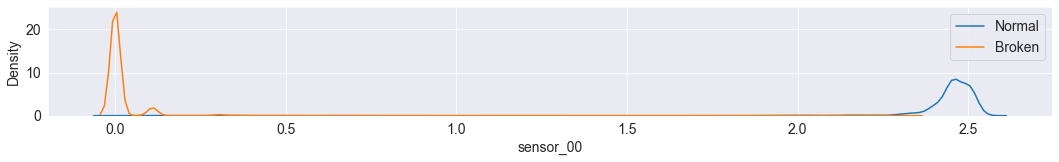

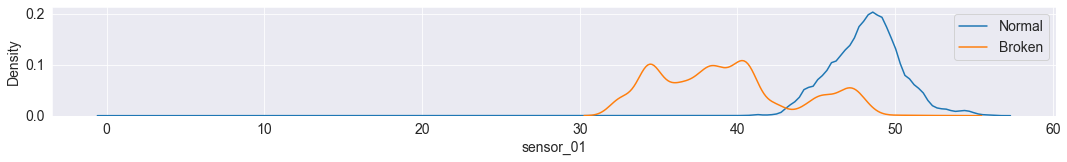

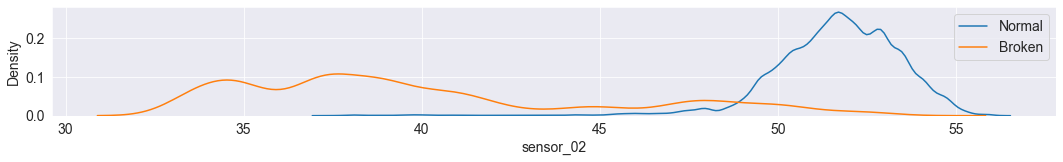

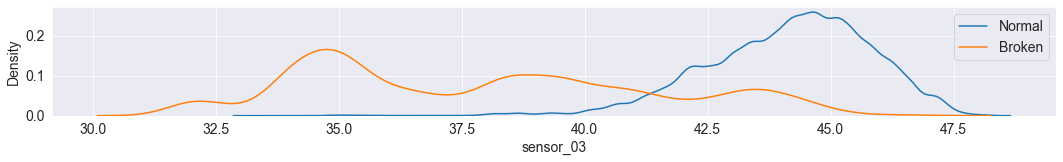

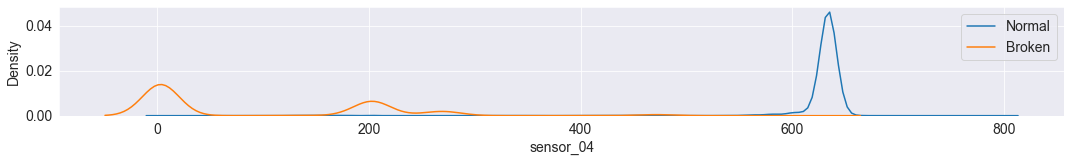

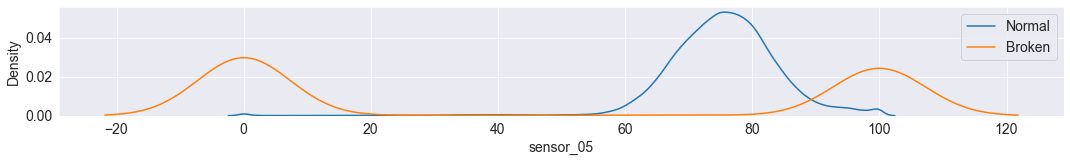

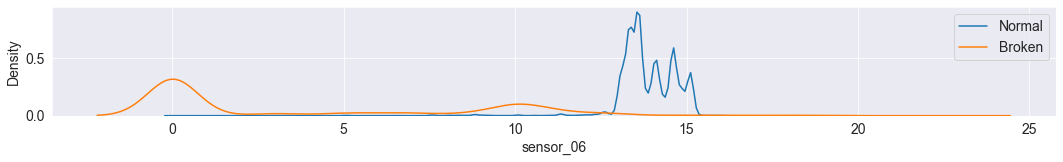

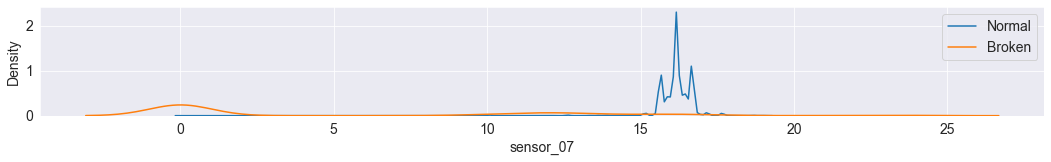

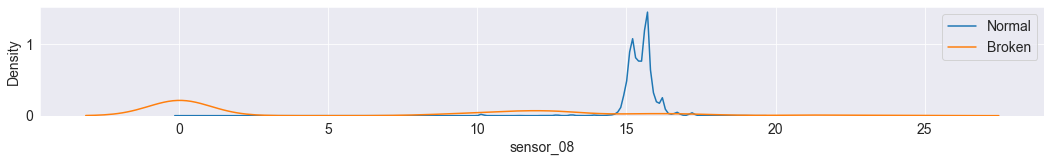

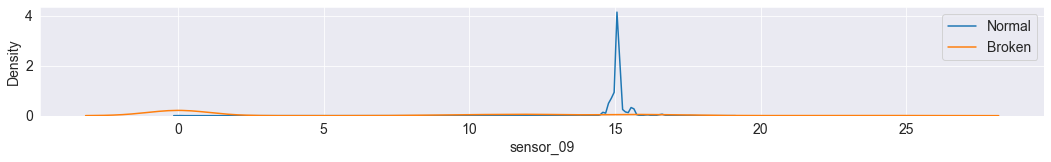

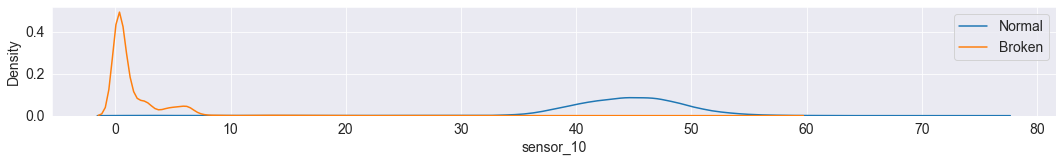

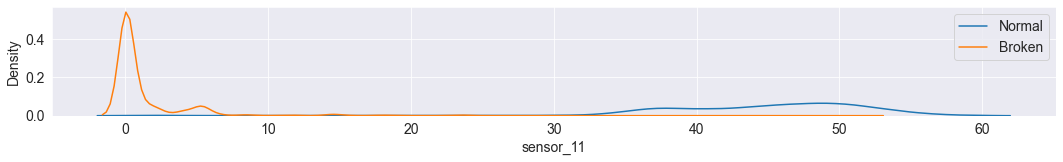

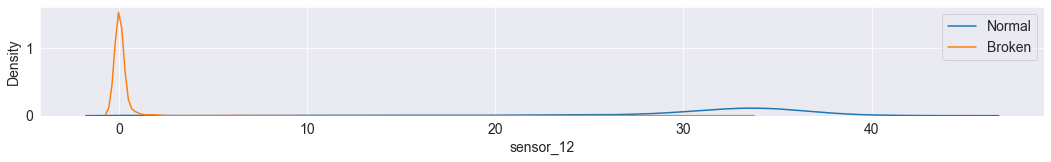

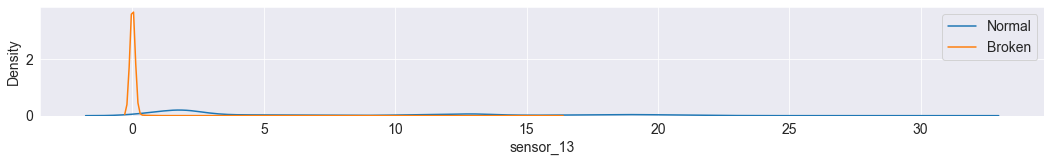

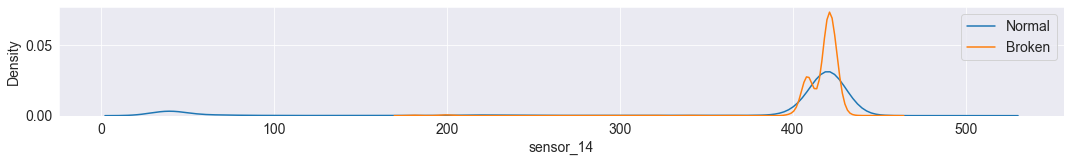

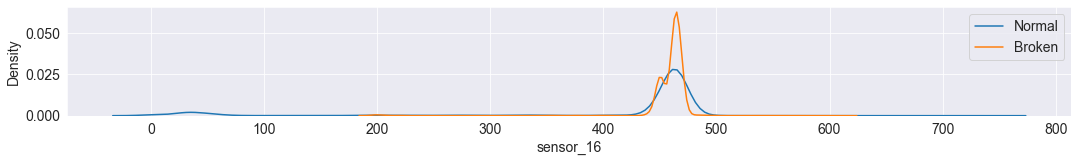

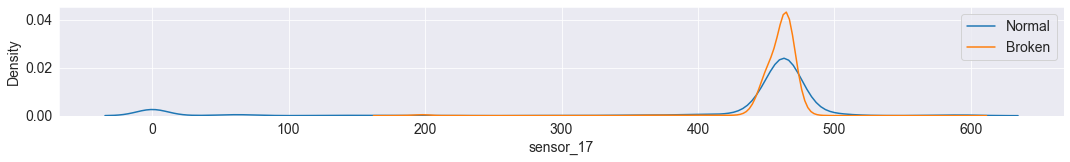

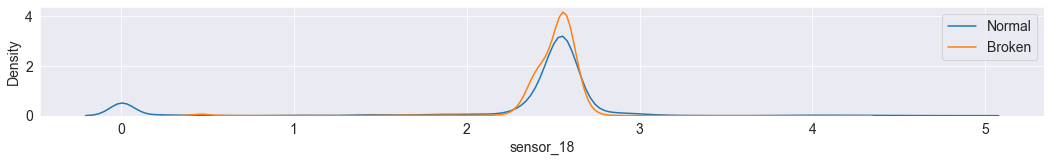

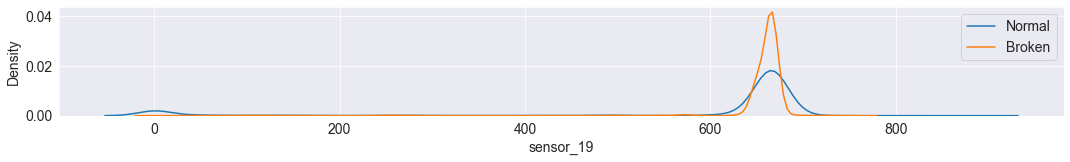

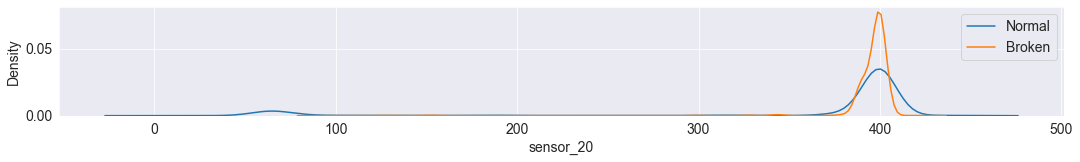

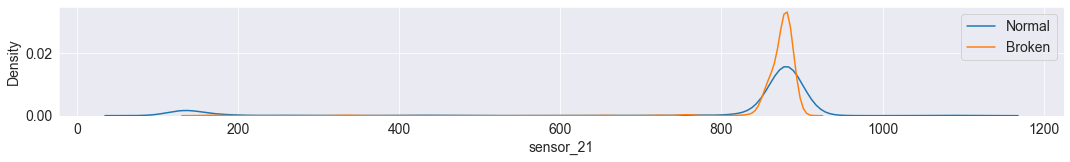

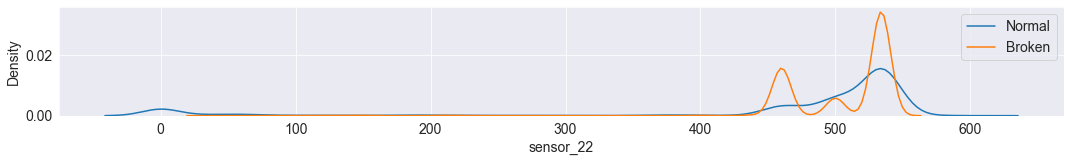

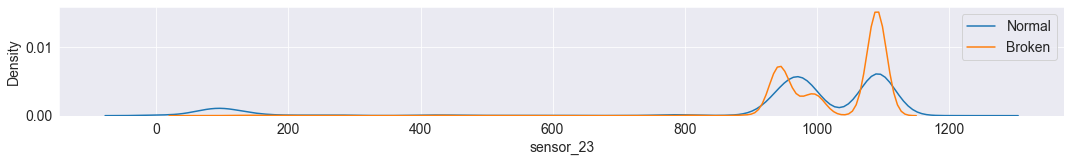

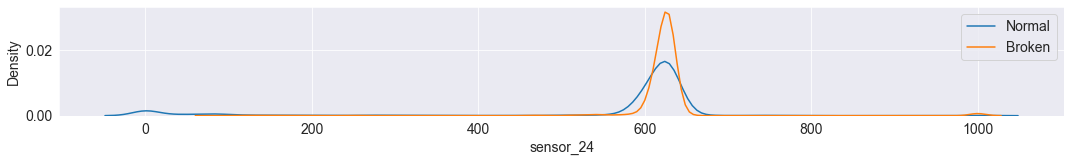

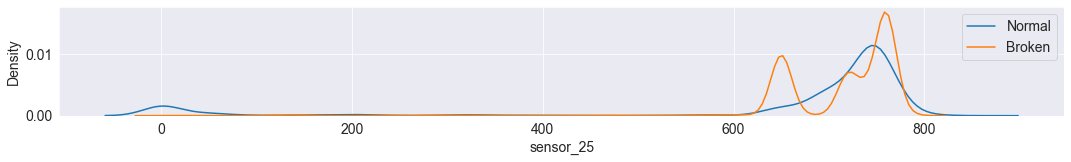

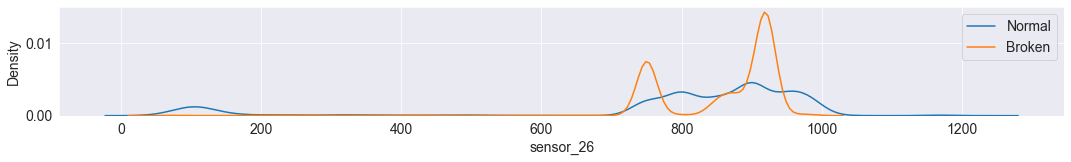

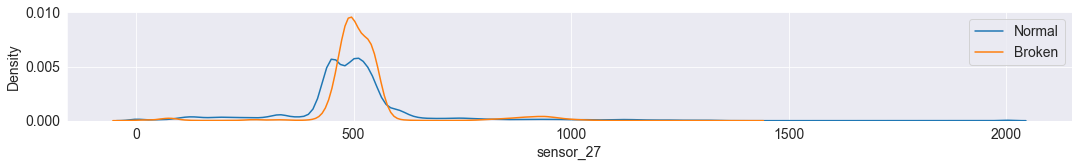

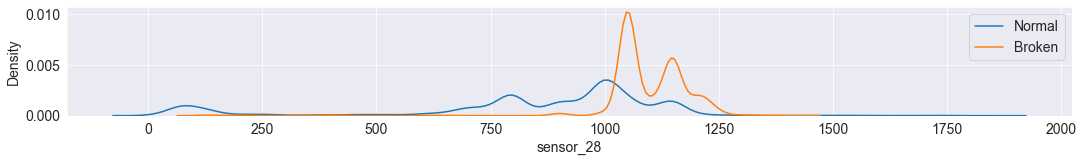

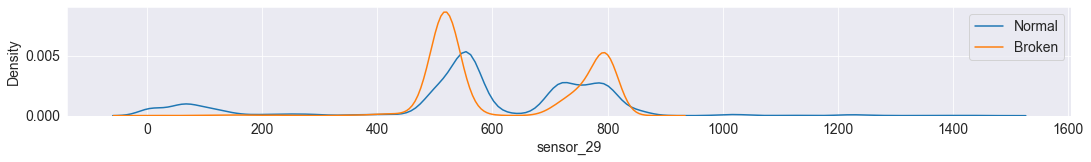

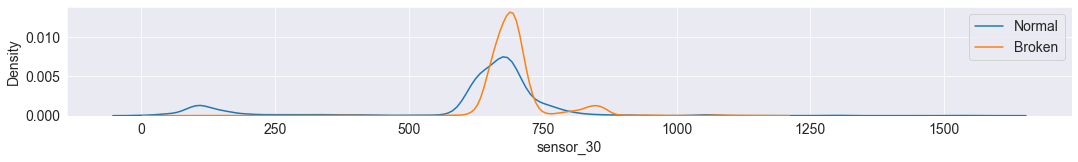

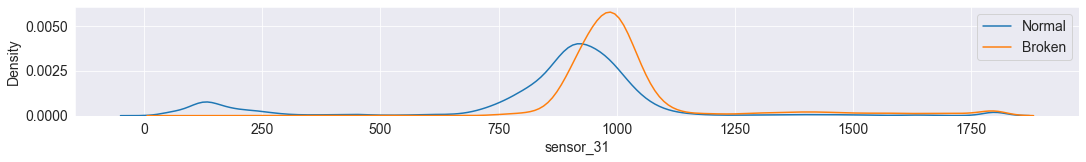

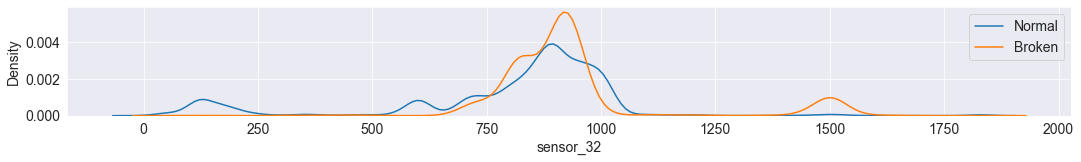

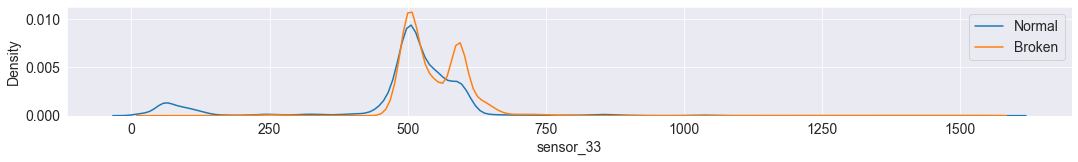

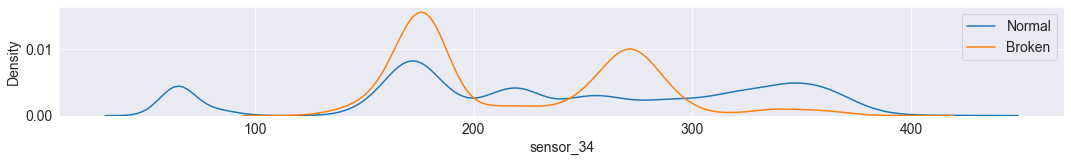

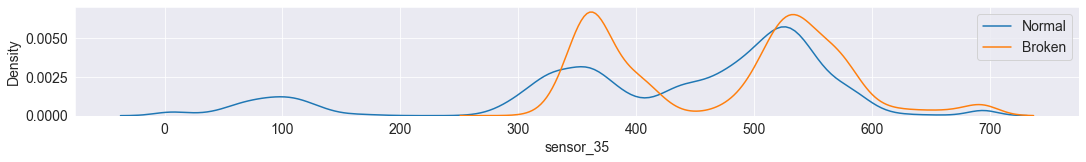

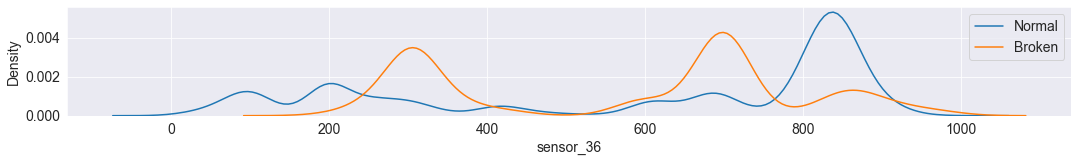

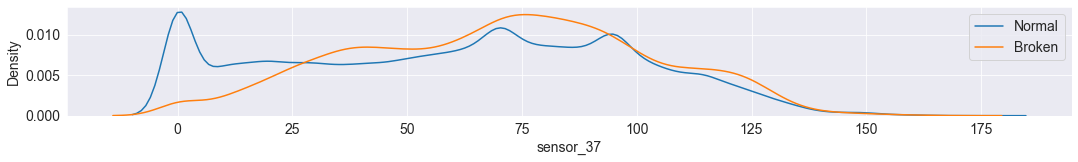

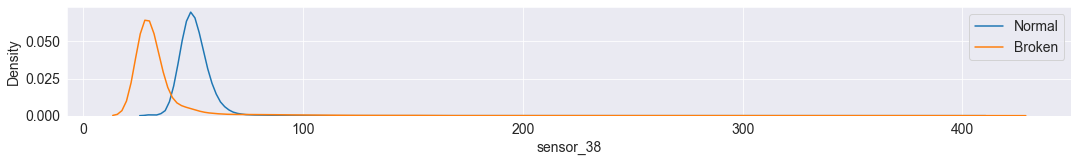

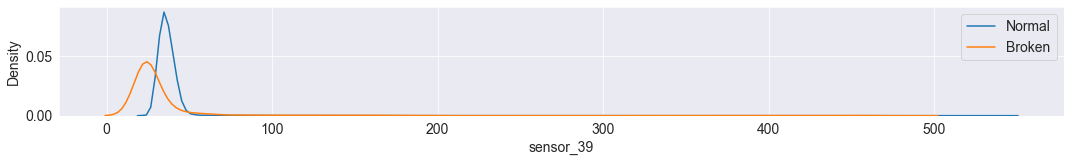

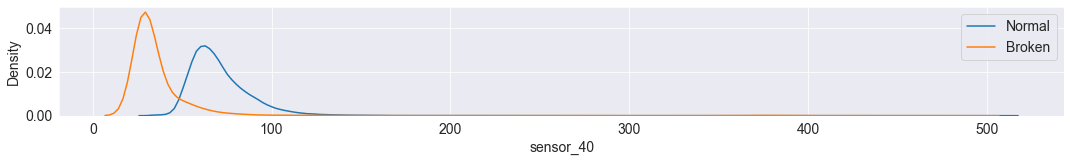

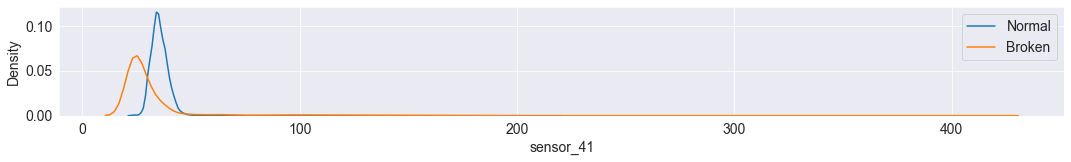

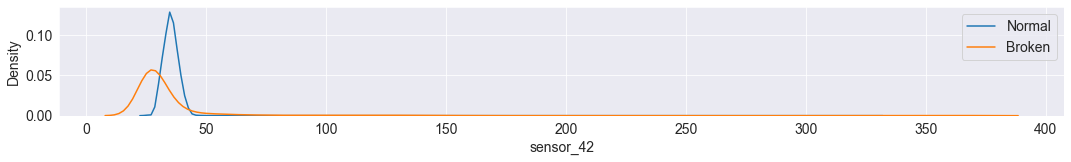

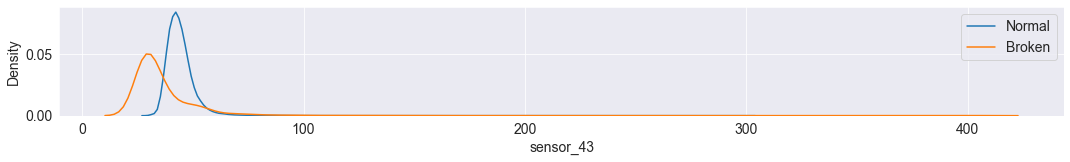

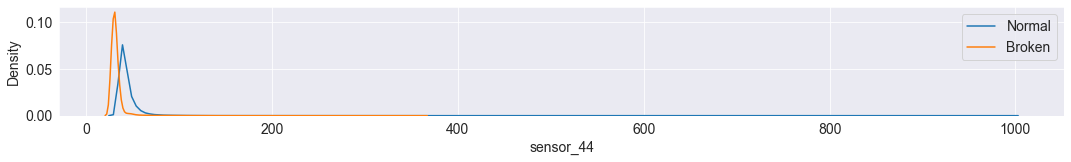

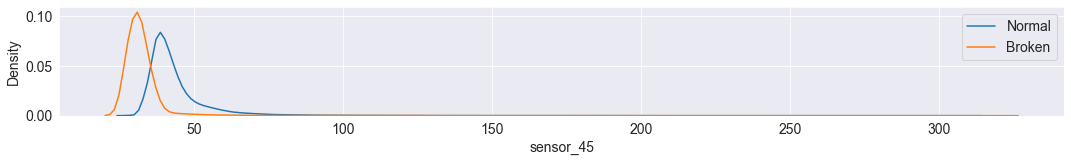

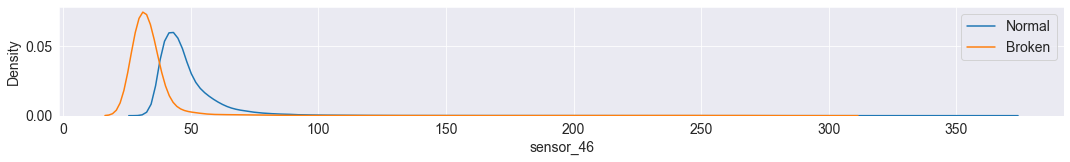

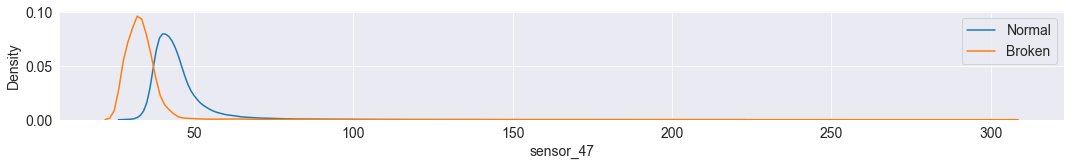

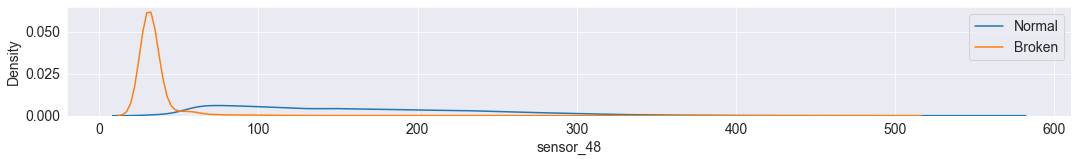

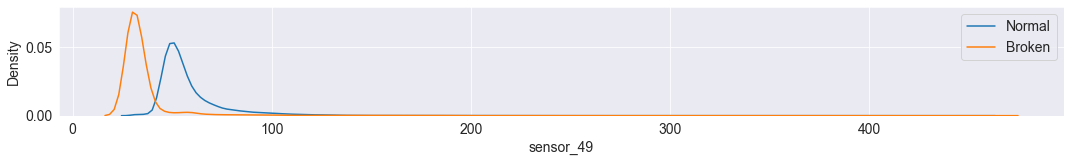

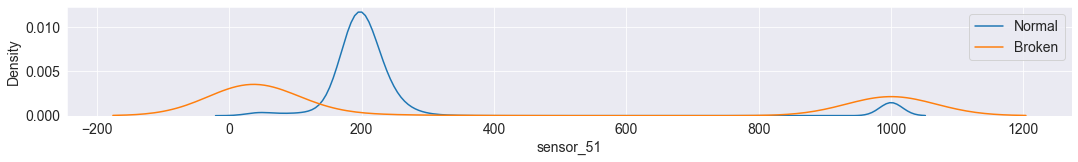

In [10]:
# распределение показаний датчиков по статусу
for sensor in sensors_col:
    plt.figure(figsize=(18,2))
    sns.kdeplot(df_fill.loc[df_fill.machine_status==1][sensor],  label='Normal')
    sns.kdeplot(df_fill.loc[df_fill.machine_status==0][sensor], label='Broken')
    plt.legend()
    plt.show()

По полученным графикам распределения можно выделить датчкики, в которых статус системы хорошо разделяется: 00, 04, 06, 07, 08, 09, 10, 11, 12. Важность также подтверждают коэффициенты корреляции между датчиками с данными номерами и сатусом состояния.

In [11]:
important_feature = ['sensor_00', 'sensor_04', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']
X = df_fill[important_feature]
y = df.machine_status

**Масштабирование данных**

Показания датчиков располагаются в различных диапазонах, поэтому необходимо выполнить масштабирование признаков, которое приведет их значения к единому виду и сделает равнозначными.

In [12]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns, index=X.index)

**Проверка на стационарность**

Выполним проверку выбранных датчиков на стационарность, так как данное свойство является одним из важнейших во временных рядах. В качестве теста на стационарность применим критерий Дикки-Фуллера.

In [26]:
%%time
for feature in X_scaled.columns:
    print(f'p-value Д-Ф для {feature}: {adfuller(X_scaled[feature])[1]}')

p-value Д-Ф для sensor_00: 1.9053190957330693e-07
p-value Д-Ф для sensor_04: 8.406450269328261e-09
p-value Д-Ф для sensor_06: 7.133986640433537e-11
p-value Д-Ф для sensor_07: 1.6796331753133526e-15
p-value Д-Ф для sensor_08: 5.722333213816164e-16
p-value Д-Ф для sensor_09: 8.242643152461945e-14
p-value Д-Ф для sensor_10: 4.705435672348053e-13
p-value Д-Ф для sensor_11: 4.294263838690748e-11
p-value Д-Ф для sensor_12: 5.829158312822788e-16
Wall time: 23min 31s


Все p-значения датчиков меньше 0,05, значит нулевая гипотеза о не-стационарности отклоняется. Таким образом, все полученные временные ря-ды являются стационарными.

**Метод главных компонент**

Так как ранее уже был произведен отбор признаков по распределению статуса системы, то воспользуемся алгоритмом PCA для создания новых признаков. 

In [14]:
pca = PCA(random_state=42)
pca.fit(X_scaled)

PCA(random_state=42)

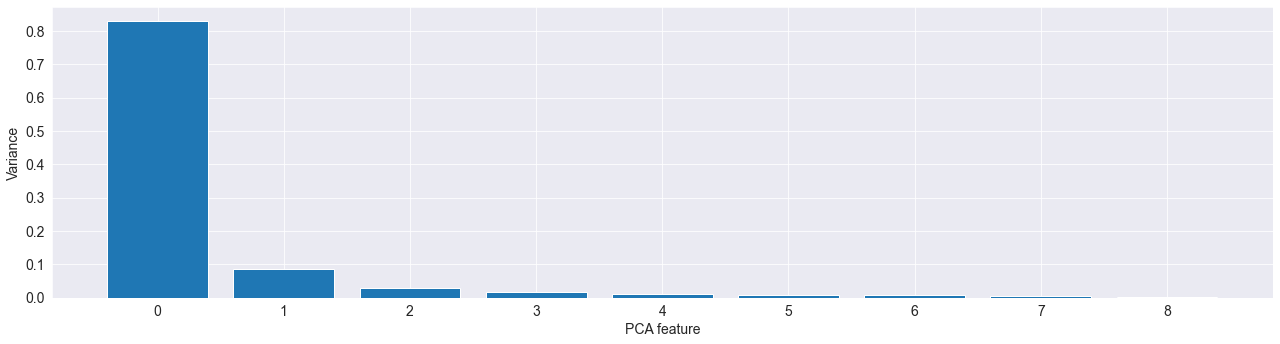

In [15]:
# Визуализация полученных результатов
features = range(pca.n_components_)
plt.figure(figsize=(18, 5))
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.tight_layout()
plt.show()

Анализ дисперсии позволяет оценить объем потерянной и сохраненной информации. В итоге получаем 16% потери информации, что считается приемлемым показателем.

In [16]:
pca = PCA()
Components = pca.fit_transform(X_scaled)
pca_results = pd.DataFrame(data=Components, columns=np.arange(0,9), index=X.index)

In [17]:
pca_results

,0,1,2,3,4,5,6,7,8
timestamp,,,,,,,,,
2018-04-01 00:00:00,-0.532335,0.008455,0.293078,-0.293446,-0.161275,-0.415323,0.096559,-0.053684,-0.108284
2018-04-01 00:01:00,-0.532335,0.008455,0.293078,-0.293446,-0.161275,-0.415323,0.096559,-0.053684,-0.108284
2018-04-01 00:02:00,-0.575963,-0.073475,0.342822,-0.272122,-0.116554,-0.411241,0.102126,-0.005574,-0.054891
2018-04-01 00:03:00,-0.614696,-0.030696,0.314510,-0.309540,-0.032628,-0.372082,0.063032,-0.032362,-0.096215
2018-04-01 00:04:00,-0.671105,-0.077642,0.291344,-0.301797,-0.020823,-0.348788,0.069905,-0.005487,-0.032090
...,...,...,...,...,...,...,...,...,...
2018-08-31 23:55:00,-1.319242,-0.369622,0.675259,-0.321203,-0.147485,0.199289,-0.067759,-0.001517,0.074520
2018-08-31 23:56:00,-1.335783,-0.391641,0.723658,-0.325172,-0.135549,0.223491,-0.092535,-0.005603,0.072825
2018-08-31 23:57:00,-1.330821,-0.393832,0.749518,-0.364817,-0.096788,0.222977,-0.096635,0.003299,0.059896


В результате получаем набор данных размера (220320, 9). В процессе обработки данных не произошла потеря наблюдений, количество признаков уменьшилось почти в 6 раз. Выполнена проверка на стационарность выделенных признаков.  Признаки сформированы как новые компоненты – результат работы PCA –  имеют нормальное распределение и масштабированы. 

In [18]:
X.to_csv('X.csv')
y.to_csv('y.csv')
X_scaled.to_csv('X_scaled.csv')
pca_results.to_csv('pca_res.csv')

In [19]:
X.shape

(220320, 9)

----------------------------------------------------------------------------

In [20]:
X.head()

,sensor_00,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
timestamp,,,,,,,,,
2018-04-01 00:00:00,2.465394,634.3750,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716
2018-04-01 00:01:00,2.465394,634.3750,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716
2018-04-01 00:02:00,2.444734,638.8889,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894
2018-04-01 00:03:00,2.460474,628.1250,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221
2018-04-01 00:04:00,2.445718,636.4583,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202


In [21]:
X_scaled.head()

,sensor_00,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
timestamp,,,,,,,,,
2018-04-01 00:00:00,0.316890,0.303461,0.070107,0.207150,0.235861,0.190237,-0.350747,0.429365,0.195854
2018-04-01 00:01:00,0.316890,0.303461,0.070107,0.207150,0.235861,0.190237,-0.350747,0.429365,0.195854
2018-04-01 00:02:00,0.284652,0.334799,0.040266,0.178513,0.252479,0.175572,-0.297801,0.479376,0.291931
2018-04-01 00:03:00,0.309213,0.260071,0.037781,0.242401,0.278590,0.200017,-0.238931,0.516047,0.250730
2018-04-01 00:04:00,0.286188,0.317924,0.050214,0.231386,0.278590,0.200017,-0.163722,0.547210,0.278394


In [22]:
y.head()

timestamp
2018-04-01 00:00:00    NORMAL
2018-04-01 00:01:00    NORMAL
2018-04-01 00:02:00    NORMAL
2018-04-01 00:03:00    NORMAL
2018-04-01 00:04:00    NORMAL
Name: machine_status, dtype: object

In [23]:
pca_results.head()

,0,1,2,3,4,5,6,7,8
timestamp,,,,,,,,,
2018-04-01 00:00:00,-0.532335,0.008455,0.293078,-0.293446,-0.161275,-0.415323,0.096559,-0.053684,-0.108284
2018-04-01 00:01:00,-0.532335,0.008455,0.293078,-0.293446,-0.161275,-0.415323,0.096559,-0.053684,-0.108284
2018-04-01 00:02:00,-0.575963,-0.073475,0.342822,-0.272122,-0.116554,-0.411241,0.102126,-0.005574,-0.054891
2018-04-01 00:03:00,-0.614696,-0.030696,0.314510,-0.309540,-0.032628,-0.372082,0.063032,-0.032362,-0.096215
2018-04-01 00:04:00,-0.671105,-0.077642,0.291344,-0.301797,-0.020823,-0.348788,0.069905,-0.005487,-0.032090


In [24]:
X_scaled.describe().T[['min', '50%', 'max']].sort_values(by='50%')

,min,50%,max
sensor_06,-4.539987,0.144702,3.108690
sensor_08,-4.872492,0.197881,3.117619
sensor_09,-4.896585,0.200017,3.551305
sensor_07,-4.705622,0.218165,2.480685
sensor_10,-3.428769,0.233266,2.863870
sensor_11,-3.210253,0.263884,1.384816
sensor_04,-4.081217,0.291408,1.453301
sensor_00,-3.530077,0.301539,0.447373
sensor_12,-2.880616,0.334122,1.568413


In [25]:
pca_results.describe().T[['min', '50%', 'max']].sort_values(by='50%')

,min,50%,max
0,-2.330486,-0.690945,12.065026
1,-6.795952,-0.122187,8.747882
3,-2.935507,-0.024007,3.033043
8,-2.406549,-0.010706,3.376392
7,-4.207334,-0.002485,5.028693
6,-6.119721,-0.000884,6.288679
4,-3.683800,-0.000157,4.231204
5,-2.770784,0.010546,3.429532
2,-2.587382,0.073052,3.466646
